### Problem Description

Using the dataset of several hundred bank users, we will train a self-organizing map model, and with it detect user with the unusal behaviour. In addition, our model will help us target those bank customers who could be abusing their credit cards. 

### The Approach

This project consists of the following steps:

1. Importing and preprocessing the data for trainig the model
2. Training the model and visualizing the results
3. Targeting the potential frauds

### Importing and Preprocessing the Data

First we'll import and scale the data, so it can be used to train our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Credit_Card_Applications.csv')

data.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


Each column of the dataset represent some information about a bank user. What each column represents is obscured because of the confidentiality. This is a problem which can be actually tackled only by a machine, since for a human it's not possible to make sense and percive patterns in a data presented this way.

The last collumn in the dataset tells wheather the credit card application was or wasn't approved by a bank. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  690 non-null    int64  
 1   A1          690 non-null    int64  
 2   A2          690 non-null    float64
 3   A3          690 non-null    float64
 4   A4          690 non-null    int64  
 5   A5          690 non-null    int64  
 6   A6          690 non-null    int64  
 7   A7          690 non-null    float64
 8   A8          690 non-null    int64  
 9   A9          690 non-null    int64  
 10  A10         690 non-null    int64  
 11  A11         690 non-null    int64  
 12  A12         690 non-null    int64  
 13  A13         690 non-null    int64  
 14  A14         690 non-null    int64  
 15  Class       690 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 86.4 KB


We see that we have quite clean data at hands. We will construct matrix of features using all the last column. Since this is an unsupervised model, the last column will be used later for labeling. We also scale the data using the `MinMaxScaler`. We keep the first column `Customer ID` in the training set, even though it has no predictive power. Becouse each ID is unique, it won't affect detecting the behaviour patterns, and we will actually need it for the future reference. 

In [4]:
customers = data['CustomerID']
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
X.shape

(690, 15)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
X = scaler.fit_transform(X)

### Training the SOM and Visualizing the Results


It's time to train our SOM model. We will make a grid of 10x10 neural nodes, which will form an SOM mask. Sparse nodes, i.e. nodes that have only several other neural nodes in their neighborhood are considered as the outlier configurations, and can indicate a pontetial fraud. 

In [8]:
from minisom import MiniSom

som = MiniSom(x = 10, y = 10, input_len = X.shape[1])
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

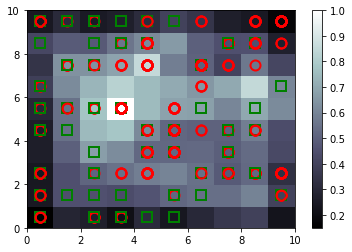

In [9]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

In the above graph, each node cluster is represented by a small square. The darker the square is, the denser the cluster it is, i.e. it has more other neural nodes close to it. The white squares are the sparse nodes. They have none or a very small number of other nodes clustered around them, and they can imply potential frauds.

The squares and circles represent our customer data. The customres who belong to darker squares exhibit the usual behaviour. Those who fall into the white squares are the potential frauds. 

Red circles signify customers who had their credit card application rejected, while the green squares are for those who had their application approved. Red circle on the white square is a good thing, because it means that the suspicious behaviour was noticed by a bank clerk, and the application for the credid card didn't pass. However, the green rectangle on a white square is most likely a fraud: a customer with (probably unnoticed) suspicious behaviour was given a credit card.

### Finding the Potencial Frauds

As we see above, we have a white square on the coordinates $(3,5)$, and within it both the red circle and the green square. This means that there are customers showing an unusal behaviour with the approved credit card, and that they could be potential frauds. The following code will extract and list those customers.

In [26]:
neural_nodes = som.win_map(X)
pot_frauds = neural_nodes[(3,5)]
pot_frauds = scaler.inverse_transform(pot_frauds)
pot_frauds = pot_frauds[:,0]

print('The following customers are potential frauds, who had their credit card approved:\n')

for cust in pot_frauds:
    
    app = data[data['CustomerID'] == cust]['Class'].values
    
    if (bool(app)):
        app = 'Credit card approved, potential fraud!'
        print(f'Customer: {int(cust)}')

The following customers are potential frauds, who had their credit card approved:

Customer: 15699238
Customer: 15757434
Customer: 15673907
Customer: 15599272


### Conclusions

Using the SOM we managed to write a simple procedure for detecting potential credit card abuses. Moreover our unsupervised learning model was trained on a relatively small dataset and was extremely fast to train.